In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_N, make_FP_axs, same_stim_trial, take_names, get_filename
from tools_lnd import gen_X_from_model_dir_epoch, gen_trials_from_model_dir, gen_X_from_model_dir

In [24]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig3','interp_stim')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [25]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'#'diag'
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '0'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

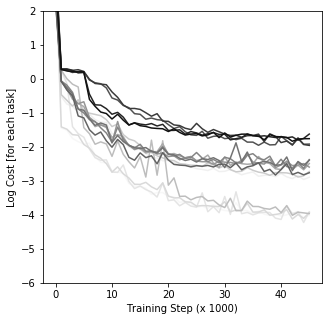

In [26]:
rule_trains = rules_dict['all']
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for ri in range(len(rule_trains)):
    r = rule_trains[ri]
    c = cmap((ri+1)/(len(rule_trains)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+r])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
# plt.title(m)
plt.show()    

In [27]:
# %matplotlib notebook

In [28]:
def make_lil_axes(ax,axes_labels,fontsize = 20):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    [x1,x2] = ax.get_xlim()
    x1 = x1*.8
    x2 = x2*.8
    x_diff = x2-x1
    [y1,y2] = ax.get_ylim()
    y1 = y1*.8
    y2 = y2*.8
    y_diff = y2-y1

    plt.plot([x1,x1+x_diff/10],[y1,y1],'-k')
    plt.plot([x1,x1],[y1,y1+y_diff/10],'-k')
    plt.text(x1,y1-y_diff/10,axes_labels[0],fontsize = fontsize)
    plt.text(x1-x_diff/6,y1+y_diff/10,axes_labels[1],fontsize = fontsize)
    ax.set_yticks([])
    ax.set_xticks([])

In [29]:
def var_ex_X_task(m, rule_ax, rule, epoch_set, batch_size = 1000, 
                  plot_legend = False,fontsize = 20):

    _, rule_name, _, _ = take_names(epoch_set[0],rule)
    _, rule_name_ax, _, _ = take_names(epoch_set[1],rule_ax)

    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False,batch_size = batch_size)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    n_components = len(X)-1
    pca = PCA(n_components = n_components)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_ax,mode='random',noise_on = False,batch_size = batch_size)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = n_components)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    fig = plt.figure(figsize=(2.7,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .2,
             label = 'Same Task PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .2,label = 'Other Task PCs')
    
    tick_fontsize = fontsize*.75
    label_fontsize = fontsize*1
    plt.xlabel('N PCs',fontsize = label_fontsize)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name +'\n Variance Explained',fontsize = label_fontsize)
    plt.ylabel('Variance Explained',fontsize = label_fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([.2,.4,.6,.8,1])
    ax.set_yticklabels([.2,.4,.6,.8,1],fontdict={'fontsize':tick_fontsize})
    ax.set_xticks([n_components - (n_components%100),])
    ax.set_xticklabels([n_components - (n_components%100),],fontdict={'fontsize':tick_fontsize})
    ax.set_ylim([0,1.1])
    ax.set_xlim([-20,n_components+20])

    if plot_legend==True:
        plt.legend()

In [30]:
def plot_task_overlap(m,ri_set,epoch_set = ['stim1','stim1'],tit = [],ri_axs = 0, plot_legend = False,
                      figsize = 4,fontsize = 20):
    fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': fontsize})

    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    axs = 'pca_h'
    rule_str = '_'.join(str(r) for r in rule_set)

    cmap_grad = plt.get_cmap('plasma')
    if ri_axs==1:
        cmap_discrete = ['dimgray','gainsboro']
    else:
        cmap_discrete = ['gainsboro','dimgray']
        
    epoch = epoch_set[ri_axs]
    rule = rule_set[ri_axs]

    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    filename,_ = get_filename(trial,epoch,0)
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
    epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
    epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])

    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,(T_inds[0]-1):T_inds[-1]],(1,2,0))

        ax = plt.subplot(111)

        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
               linewidth = 18,linestyle = '-', alpha = .1, markersize = 20)
        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 6, 
               linestyle =  '-', alpha = .9, markersize = 10)

    if len(tit)<1:
        tit = rule_name1+' vs.'+rule_name2
    plt.title(tit,fontsize = fontsize,fontweight='bold')

    tit_save = '_'.join(tit.split())
    make_lil_axes(ax,['PC1','PC2'])

    fig_fldr = '2_task_viz'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.png'))
    plt.show()

    var_ex_X_task(m, rule_set[ri_axs], rule_set[1-ri_axs], [epoch_set[1-ri_axs],
                                                                epoch_set[ri_axs]], plot_legend = plot_legend)
    fig_fldr = '2_task_var'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.png'))
    plt.show()

In [31]:
from tools_lnd import interp_h_tasks_w_context
def gen_trial_set(ri_set):
    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    return [trial1,trial2]

In [32]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'

In [ ]:
ri_set = [3,1]
epoch_list = ['stim1','go1']
trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(m, ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_stim',
                         fig_width = 7,fig_height = 4, figpath = figpath)

In [ ]:
ri_set = [13,14]
epoch_list = ['stim1','stim1']
trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(m, ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_stim',
                         fig_width = 7,fig_height = 4, figpath = figpath)

In [14]:
# ri_set = [10,9]
# epoch_list = ['stim1','stim1']
# trial_set = gen_trial_set(ri_set)
# interp_h_tasks_w_context(m, ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_stim',
#                          fig_width = 13,fig_height = 4, figpath = figpath)

In [15]:
# ri_set = [10,8]
# epoch_list = ['stim1','stim1']
# trial_set = gen_trial_set(ri_set)
# interp_h_tasks_w_context(m, ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_stim',
#                          fig_width = 10,fig_height = 4, figpath = figpath)

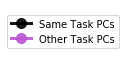

In [10]:
fig = plt.figure(figsize=(1, 1))

ax = plt.subplot(111)
ax.plot(1,1,'-ok',linewidth = 3,markersize = 10,alpha = .9,
         label = 'Same Task PCs')
ax.plot(1,1,'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
         alpha = .9,label = 'Other Task PCs')
ax.set_xlim([-1,0])
ax.set_ylim([-1,0])
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

fig_fldr = '2_task_var'
if not os.path.exists(os.path.join(figpath,fig_fldr)):
    os.makedirs(os.path.join(figpath,fig_fldr))

plt.savefig(os.path.join(figpath,fig_fldr,'legend.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figpath,fig_fldr,'legend.png'))
plt.show()

In [10]:
from tools_lnd import interp2d
def var_ex_X_task(m, rule_set, epoch_set, n_components = 200, batch_size = 1000, plot_legend = False):

    rule_name_set = {}
    _, rule_name_set[0], _, _ = take_names(epoch_set[0],rule_set[0])
    _, rule_name_set[1], _, _ = take_names(epoch_set[1],rule_set[1])

    trial = gen_trials_from_model_dir(m,rule_set[0],mode='random',noise_on = False,batch_size = 200)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    pca = PCA(n_components = n_components)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_set[1],mode='random',noise_on = False,batch_size = 200)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = n_components)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    plt.rcParams.update({'font.size': 16})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .5,
             label = rule_name_set[0] + ' PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .5,label = rule_name_set[1] + ' PCs')
    plt.xlabel('N PCs',fontsize = 18)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name_set[0] +'\n Variance Explained',fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([n_components,])
    ax.set_ylim([0,1.1])
    ax.set_xlim([-.05*n_components,2.5*n_components])
    if plot_legend==True:
        plt.legend(loc='upper center', bbox_to_anchor=(0.01, 1.3))


In [10]:
def get_interp_filename(trial1,trial2,epoch_list,t_set):

    epoch_list = ['stim1','stim1']

    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

def interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',tol_q = 1e-6,interp = True,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .001,
            n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = [],fig_size = 4,
            alpha_max = 1.1,fontsize = 20,title_y = .9,set_tit = []):
    
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': fontsize})
    n_interp = 20

    epoch = epoch_set[rule_axs]
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule_set[0])
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule_set[1])
    if epoch_name1==epoch_name2:
        epoch_name = epoch_name1

    if interp:
        if script_name == 'interp_tasks_small_init_stim':
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            r2 = np.where([rules_dict['all'][i]==rule_set[1] for i in range(len(rules_dict['all']))])[0][0]
            trial2 = same_stim_trial(trial1, r2) 
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            filename_interp = get_interp_filename(trial1,trial2,['stim1','stim1'],t_set)
            
        elif script_name == 'interp_tasks_small_init_mov':
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            trial2 = gen_trials_from_model_dir(m,rule_set[1],mode='test',noise_on = False)
            trial2 = same_mov_inds(trial1, trial2) 
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

        for step_i in range(n_interp):#[9, 10, 8, 11, 7, 12, 6, 13, 5, 14, 4, 15, 3, 16, 2, 17, 1, 18, 19, 0]:
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)

                stability_metric = alpha_max - np.max(eig_decomps[fp_ind]['evals'].real)
                facecolors_3d = c
                facecolors_2d = c
                edgecolors = 'w'
                al = stability_metric
                
                if np.max(eig_decomps[fp_ind]['evals'].real)>1:
                    if plot_unstable:
                        plt.plot(fp[0],fp[1],'o',c = edgecolors,linewidth = 10,markersize = 20,markerfacecolor = facecolors_2d,
                                 alpha = stability_metric)

                else:

                    plt.plot(fp[0],fp[1],'o',c = edgecolors,linewidth = 10,markersize = 20,markerfacecolor = facecolors_2d,
                                 alpha = stability_metric)
    
    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]
        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/8))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
        x_epoch = np.transpose(x[:,:,T_inds_plot],(1,2,0))

        ax = plt.subplot(111)
        stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
        y_locs = trial.y_loc[-1,:]

        if color_stim:
            plot_N( x_epoch[trial_set,:,:],D_use.T,stim1_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)
        else:
            plot_N(x_epoch[trial_set,:,:],D_use.T,y_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)

        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = fig_size/2, 
               linestyle =  '-', alpha = .9, markersize = 10)

    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
    ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()

    if len(set_tit)>0:
        tit = set_tit 
        tit_name = set_tit
    elif rule_set[0]==rule_set[1]:
        tit = 'Single Task : '+rule_name1+'\n '+r"$\bf{"+epoch_name1+"}$"+' vs. '+r"$\bf{"+epoch_name2+"}$"+' dynamics' 
        tit_name = rule_name1+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_2d'
    else:       
        tit = r"$\bf{"+rule_name1+"}$"+' vs. '+r"$\bf{"+rule_name2+"}$"+ '\n '+epoch_name1+' dynamics'
        tit_name = rule_name1+'_v_'+rule_name2+'_'+epoch_name1+'_dynamics_2d'   
    plt.title(tit,y = title_y)

    _, ax_rule_name, _, _ = take_names(epoch,rule_set[rule_axs])
    axes_label1 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name1+' PC1'
    axes_label2 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name1+' PC2'
    make_lil_axes(ax,[axes_label1,axes_label2],fontsize = fontsize)

    fig_fldr = 'interp_fps'
    if not os.path.exists(os.path.join(figpath,fig_fldr,script_name)):
        os.makedirs(os.path.join(figpath,fig_fldr,script_name))

    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.png'))
    plt.show()

TypeError: var_ex_X_task() got an unexpected keyword argument 'n_components'

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


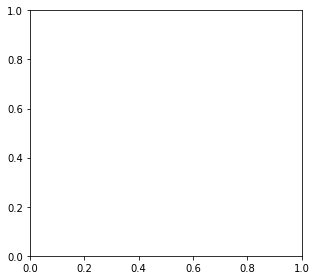

In [11]:
from tools_lnd import comp_eig_decomp, make_lil_axes

ri_sets = [[3,1],[13,14],[10,9]]
epoch_sets = [['stim1','go1'],['stim1','stim1'],['stim1','stim1']]
set_tits = ['Different Motifs','Category Motif','Decision Motif']
ruleset = 'all'

for set_i in range(len(ri_sets)):
    ri_set = ri_sets[set_i]
    epoch_set = epoch_sets[set_i]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    set_tit = set_tits[set_i]
    
    fig = plt.figure(figsize=(4.5,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)

    for seed_ind in range(3):
        seed=str(seed_ind)
        m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

        if seed=='0':
            plot_legend = True
        else:
            plot_legend = False

        var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 40)

    rule_names = rules_dict['all'][ri_set[0]]+'_'+rules_dict['all'][ri_set[1]]
    figname = 'var_ex_'+rule_names+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

    fig_fldr = os.path.join(figpath,'var',rule_names)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
    plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
    plt.show()

    seed=str(0)
    m = os.path.join(p,data_folder,'all',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
    
    t_set = [0,0]
    rule = rules_dict['all'][ri_set[0]]
    filename = 'filename'
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch_set[0], axs = 'pca_h', clust = 'False')
    
    interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_stim',tol_q = 1e-6,interp = False,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .000001,
             n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = figpath,fig_size = 6,
             fontsize = 20,title_y = .9,set_tit = set_tit)


In [12]:
def get_interp_filename(trial1,trial2,epoch_list,t_set):

    # if epoch_list==['fix1','fix1'] & rule1[:5]=='delay':
    #     epoch_list = ['delay1','delay1']

    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc1,2)) #DEBUGGING REMOVE THIS LINE

    return filename


In [13]:
def plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name,tol_q = 1e-6,t_set = [0,0],
                     q_thresh = .0000001,fig_size = 4, lims = [], fac_mult_lims = 1.5,
                     stability_thresh = 1,fp_first = True, color_stim = True, step_set = [0,19],
                     figpath = 'plot_bifurc_ends',ruleset = 'all',fontsize = 20, 
                     plot_unstable = True,plot_expansion = False):
    
    cmap_discrete = ['w','k']
    cmap_grad = plt.get_cmap('plasma')

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))

    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    trial_set = [trial1, trial2]

    trial_inds = range(0,np.shape(trial1.x)[1],int(np.shape(trial1.x)[1]/8))

    for ri in [0,1]:
        fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
        ax = fig.add_axes([0,0,1,1])

        sorted_fps, eig_decomps = load_fps_from_interp(m,script_name,rule_str,tol_q,filename_interp,
                                                         step_set[ri],q_thresh)

        if fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)
        
        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]
        print(c_master)

        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))


        cmap_state = plt.get_cmap('hsv')
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))

        lw = 10
        plot_N(x_epoch[trial_inds,:,:], D_use.T, c_set[trial_inds], linewidth = fig_size*2, alpha = .2)
        plot_N(x_epoch[[s,],:,:], D_use.T, c, linewidth = lw, alpha = .8 ,markersize = 16)
        plot_N(x_epoch[[s,],:,:], D_use.T, c_master, linewidth = lw/3, alpha = 1 ,markersize = 16)

        if not fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)

        if len(lims)>0:
            ax.set_xlim([fac_mult_lims*lims[0],fac_mult_lims*lims[1]])
            ax.set_ylim([fac_mult_lims*lims[2],fac_mult_lims*lims[3]])
        else:
            [x1,x2] = ax.get_xlim()
            [y1,y2] = ax.get_ylim()
            ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
            ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])

        epoch_name, rule_name, _, _ = take_names(epoch_set[ri],rule_str[ri])

        tit = r"$\bf{"+rule_name+"}$"+'\n '+epoch_name+' dynamics'
        tit_name = rule_name+'_'+epoch_name+'_dynamics'
        plt.title(tit,fontsize = fontsize)#,y = .9
        fig_fldr = os.path.join(figpath,'interp_fps',ruleset,'bifurcation')
        if not os.path.exists(fig_fldr):
            os.makedirs(fig_fldr)

        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
        plt.show()

In [14]:
from tools_lnd import remove_spines

def plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_i, n_interp = 20, stability_thresh = 1,ms = 20, 
    plot_unstable = True,plot_expansion = False,rf = 100):
    cmap_grad = plt.get_cmap('plasma')
    c = cmap_grad(step_i/n_interp)

    for fp_ind in range(len(sorted_fps)):

        fp = np.dot(sorted_fps[fp_ind,:],D_use[:,[0,1]])

        stability_metric = 1
        facecolors_3d = c
        facecolors_2d = c
        edgecolors = 'w'
        al = stability_metric

        if np.max(eig_decomps[fp_ind]['evals'].real)>stability_thresh:

            if plot_expansion:
                n_arg = np.argwhere(eig_decomps[fp_ind]['evals']>1)+1
                if len(n_arg)>0:
                    for arg in range(np.max(n_arg)):
                        rdots = np.dot(np.real(eig_decomps[fp_ind]['R'][:, arg]).T,D_use[:,[0,1]])
                        ldots = np.dot(np.real(eig_decomps[fp_ind]['L'][:, arg]).T,D_use[:,[0,1]])
                        overlap = np.dot(rdots,ldots.T)
                        r = np.concatenate((fp - rf*overlap*rdots, fp + rf*overlap*rdots),0)
                        plt.plot(r[0:4:2],r[1:4:2], c = 'k' ,alpha = .2,linewidth = .5)

            if plot_unstable:
                plt.plot(fp[0],fp[1],'o',c = c,linewidth = 10,markersize = ms,markerfacecolor = 'w',
                         alpha = stability_metric,markeredgewidth=3)
        else:
            plt.plot(fp[0],fp[1],'o',c = edgecolors,linewidth = 10,markersize = ms,
                markerfacecolor = facecolors_2d,alpha = stability_metric)

    ax.set_yticks([])
    ax.set_xticks([])
    remove_spines(ax)

In [21]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',
    markersize = 10, edgecolors = []):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    print(len(clist))
    
    for s in range(S):

        if len(clist)<2:
            c = clist[0]
        elif len(clist)==4:
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize,markeredgewidth = linewidth)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, linewidth = linewidth, alpha = alpha,markersize = markersize,markeredgewidth = linewidth)
        if len(edgecolors)>0:
            plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = edgecolors, linewidth = linewidth/2, alpha = alpha, markersize = markersize)


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

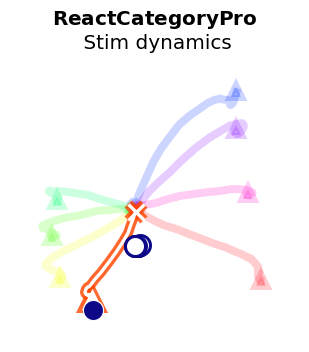

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kern

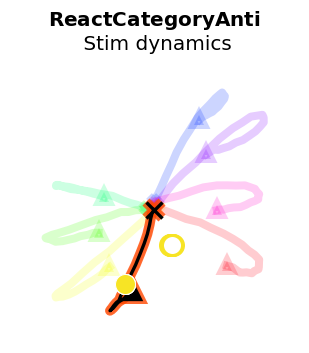

In [22]:
from tools_lnd import load_fps_from_interp, bifurc #comp_eig_decomp, make_lil_axes, bifurc, plot_bifurc_ends, bifurc

fig_size = 6
script_name = 'interp_tasks_small_init_stim'
q_thresh = 1e-7
tol_q = 1e-6
ax_labels = 'pca_h'

ri_sets = [[13,14],]#[[3,1],[13,14],[10,9]]
epoch_sets = [['stim1','stim1'],]#[['stim1','go1'],['stim1','stim1'],['stim1','stim1']]
set_tits = ['Category Motif',] #['Different Motifs','Category Motif','Decision Motif']
ruleset = 'all'

for set_i in range(len(ri_sets)):
    ri_set = ri_sets[set_i]
    epoch_set = epoch_sets[set_i]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]

    seed=str(0)
    m = os.path.join(p,data_folder,'all',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
    
    t_set = [0,0]
    rule_axs = 0
    rule = rule_set[rule_axs]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    filename = 'filename'
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch_set[0], axs = ax_labels, clust = 'False')
    
#     bifurc(m,D_use,ri_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#          n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#          figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
#                        lims = [], view_ang = [31,-52])

    plot_bifurc_ends(m,D_use,ri_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
                     stability_thresh = 1, color_stim = True, figpath = figpath, ruleset = ruleset,
                    plot_expansion = False)

#     D_use[:,0] = -D_use[:,0]
#     bifurc(m,D_use,ri_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#                color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#                title_y = .9, n_trials = 8, stability_thresh = 1, threeD = False,
#                lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
#                bifurc = False, plot_zero_plane = False)


In [ ]:
cmap_discrete = ['w','k']

In [18]:
len([cmap_discrete[0],],)

1

In [2]:
cmap_state = plt.get_cmap('hsv')
c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
s = np.argwhere(c_set == np.min(trial.stim_locs[t_set[0],[0,2]]))[0][0]
c = cmap_state(c_set[s]/(2*np.pi))

NameError: name 'plt' is not defined

In [1]:
np.shape(c)

NameError: name 'np' is not defined

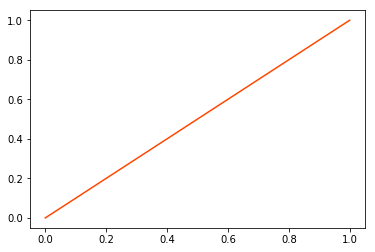

In [18]:
plt.plot([0,1],[0,1],'-',c = c)

In [11]:
fig_size = 6
script_name = 'interp_tasks_small_init_stim'
q_thresh = 1e-6
tol_q = 1e-6
ax_labels = 'pca_h'

ri_sets = [[3,1],[13,14],[10,9]]
epoch_sets = [['stim1','go1'],['stim1','stim1'],['stim1','stim1']]
set_tits = ['Different Motifs','Category Motif','Decision Motif']
ruleset = 'all'

set_i = 0
rule_set = ri_sets[set_i]
epoch_set = epoch_sets[set_i]
# rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]

seed=str(0)
m = os.path.join(p,data_folder,'all',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

t_set = [0,0]
rule_axs = 0
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename = 'filename'
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch_set[0], axs = ax_labels, clust = 'False')

fac_mult_lims = 2
fp_first = False
stability_thresh = 1
color_stim = True

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/mod

In [14]:
from tools_lnd import get_interp_filename,remove_spines,comp_eig_decomp

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

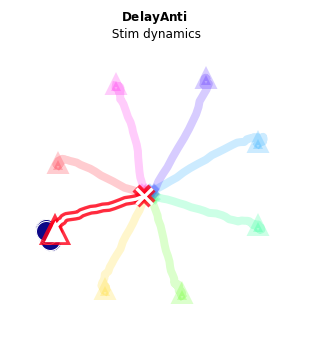

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

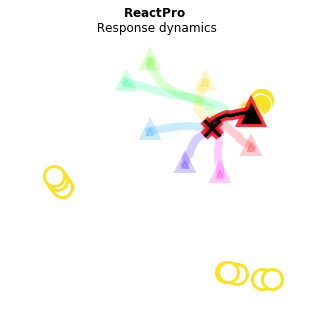

In [23]:
tol_q = 1e-6
t_set = [0,0]
q_thresh = .0000001
fig_size = 4
lims = []
fac_mult_lims = 1.5
stability_thresh = 1
fp_first = True
color_stim = True
step_set = [0,19]
figpath = 'plot_bifurc_ends'
ruleset = 'all'
    
cmap_discrete = ['w','k']
cmap_grad = plt.get_cmap('plasma')

rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

# if color_stim:
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
#     trial2 = same_stim_trial(trial1, rule_set[1]) 
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
# else:
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
#     trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
#     trial2 = same_mov_inds(trial1, trial2) 
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))

filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
trial_set = [trial1, trial2]

trial_inds = range(0,np.shape(trial1.x)[1],int(np.shape(trial1.x)[1]/8))

for ri in [0,1]:
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    ax = fig.add_axes([0,0,1,1])

    sorted_fps, eig_decomps = load_fps_from_interp(m,script_name,rule_str,tol_q,filename_interp,
                                                     step_set[ri],q_thresh)

    if fp_first:
        plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], stability_thresh = stability_thresh)
    
    rule = rule_str[ri]
    epoch = epoch_set[ri]
    c_master = cmap_discrete[ri]

    trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[ri])
    T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))


    cmap_state = plt.get_cmap('hsv')
    if color_stim:
        c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
        s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
        c = cmap_state(c_set[s]/max(np.min(trial1.stim_locs[:,[0,2]],axis=1)))
    else:
        c_set = trial.y_loc[-1,:]
        s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
        c = cmap_state(c_set[s]/max(trial1.y_loc[-1,:]))

    lw = 10
    plot_N(x_epoch[trial_inds,:,:], D_use.T, c_set[trial_inds], linewidth = fig_size*2, alpha = .2)
    plot_N(x_epoch[[s,],:,:], D_use.T, c, linewidth = lw, alpha = .8 ,markersize = 16)
    plot_N(x_epoch[[s,],:,:], D_use.T, [cmap_discrete[ri],], linewidth = lw/3, alpha = 1 ,markersize = 16)

    if not fp_first:
        plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], stability_thresh = stability_thresh)

    if len(lims)>0:
        ax.set_xlim([fac_mult_lims*lims[0],fac_mult_lims*lims[1]])
        ax.set_ylim([fac_mult_lims*lims[2],fac_mult_lims*lims[3]])
    else:
        [x1,x2] = ax.get_xlim()
        [y1,y2] = ax.get_ylim()
        ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
        ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])

    epoch_name, rule_name, _, _ = take_names(epoch_set[ri],rule_str[ri])

    tit = r"$\bf{"+rule_name+"}$"+'\n '+epoch_name+' dynamics'
    tit_name = rule_name+'_'+epoch_name+'_dynamics'
    plt.title(tit)#,y = .9

    plt.show()

In [16]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True, two_period = False,
                    periods = ['Context','Stimulus']):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0)+.012,y_origin-y_diff*np.sin(np.pi/2)+.03,'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 4)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = 'k',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = 'dimgray',alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = 'dimgray',alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = 'w',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = 'gainsboro',alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = 'gainsboro',alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
                
    if two_period:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = 'k',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = 'dimgray',alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,periods[0],fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = 'dimgray',alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = 'w',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = 'gainsboro',alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = 'gainsboro',alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,periods[1],fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


In [17]:
trial = gen_trials_from_model_dir(m,'dmcgo',noise_on = False)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


In [18]:
len(trial.stim_locs)/8

20.0

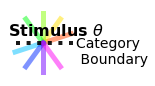

In [19]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(.9,.9),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
stim1_locs = np.min(trial.stim_locs[0:-1:20,[0,2]],axis=1) #only workds for single modality tasks
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = True, show_stim = True, two_task = False, two_period = False, 
                 periods = ['Stimulus','Response'],show_rainbow = True)

figname = 'stim_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'stim_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()